# Insurance Risk Analytics: Task 4 - Predictive Modeling and Premium Optimization

This notebook implements predictive models for claim severity and claim probability, forming the core of a risk-based pricing system. It includes data preparation, model building, evaluation, feature importance analysis with SHAP, and a premium optimization framework.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap
import joblib
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Add src to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from modeling import (
    prepare_modeling_data, 
    build_preprocessor,
    train_severity_model, 
    evaluate_model,
    analyze_feature_importance,
    save_model
)

# Enable inline plotting
%matplotlib inline

d:\Projects\Python\insurance-risk-analytics\insurance\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load data
data_path = os.path.join(os.getcwd(), '..', 'data', 'processed', 'cleaned_data.csv')
try:
    df = pd.read_csv(data_path)
except FileNotFoundError:
    logger.error(f"Data file not found at {data_path}")
    raise

# Verify required columns
required_cols = ['TransactionMonth', 'RegistrationYear', 'TotalPremium', 
                 'Province', 'VehicleType', 'Gender', 'TotalClaims']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    logger.error(f'Missing columns in dataset: {missing_cols}')
    raise ValueError(f'Missing columns in dataset: {missing_cols}')

logger.info(f'Dataset shape: {df.shape}')
logger.info(f'Columns in df: {list(df.columns)}')
logger.info(f'TotalClaims summary: {df["TotalClaims"].describe()}')
logger.info(f'TotalClaims value counts: {df["TotalClaims"].value_counts(dropna=False).to_string()}')
logger.info(f'Data types:{df[required_cols].dtypes}')
logger.info(f'NaN counts:{df[required_cols].isna().sum()}')

2025-06-18 14:35:54,668 - INFO - Dataset shape: (1000098, 53)
2025-06-18 14:35:54,670 - INFO - Columns in df: ['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium', 'TotalClaims', 'LossRatio']
2025-06-18 14:35:54,694 - INFO - TotalClaims summary: count    1.000098e+06

## Claim Severity Prediction Model

In [4]:
# Filter only policies with claims
df_claims = df[df['TotalClaims'] > 0].copy()

# Check if df_claims is empty
if df_claims.empty:
    logger.warning('df_claims is empty after filtering TotalClaims > 0. Falling back to all policies.')
    df_claims = df.copy()

logger.info(f'df_claims shape after filtering: {df_claims.shape}')
logger.info(f'Columns in df_claims before preparation: {list(df_claims.columns)}')
logger.info(f'df_claims sample:\n{df_claims.head(2).to_string()}')

# Prepare data for modeling
try:
    df_claims = prepare_modeling_data(df_claims)
except ValueError as e:
    logger.error(f'Error in prepare_modeling_data: {e}')
    raise

logger.info(f'Columns in df_claims after preparation: {list(df_claims.columns)}')
logger.info(f'df_claims sample after preparation:\n{df_claims.head(2).to_string()}')

# Verify engineered features
engineered_features = ['VehicleAge', 'UnderwrittenCovers', 'PremiumPerCover']
missing_engineered = [col for col in engineered_features if col not in df_claims.columns]
if missing_engineered:
    logger.error(f'Engineered features missing after preparation: {missing_engineered}')
    raise ValueError(f'Engineered features missing after preparation: {missing_engineered}')

# Define features and target
features = ['Province', 'VehicleType', 'Gender', 'VehicleAge', 'UnderwrittenCovers', 'PremiumPerCover']
available_features = [f for f in features if f in df_claims.columns]
if len(available_features) < len(features):
    logger.warning(f'Using fallback features: {available_features}')
    features = available_features

try:
    X = df_claims[features]
    y = df_claims['TotalClaims']
except KeyError as e:
    logger.error(f'Error selecting features: {e}')
    raise

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

logger.info(f'Training samples: {X_train.shape[0]}')
logger.info(f'Test samples: {X_test.shape[0]}')

2025-06-18 14:35:57,962 - INFO - df_claims shape after filtering: (2788, 53)
2025-06-18 14:35:57,964 - INFO - Columns in df_claims before preparation: ['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium', 'TotalClaims', 'LossRatio']
2025-06-18 14:35:57,973 - INFO - d

In [5]:
# Train and evaluate models
models = {}
model_types = ['linear', 'rf', 'xgb']

for model_type in model_types:
    logger.info(f'Training {model_type} model...')
    model = train_severity_model(X_train, y_train, model_type)
    metrics = evaluate_model(model, X_test, y_test)
    logger.info(f'Performance - RMSE: {metrics["RMSE"]:.2f}, R2: {metrics["R2"]:.2f}')
    models[model_type] = {'model': model, 'metrics': metrics}
    
    # Save model
    save_model(model, f'claim_severity_{model_type}')
    logger.info(f'Saved model to models/claim_severity_{model_type}.joblib')

2025-06-18 14:36:03,053 - INFO - Training linear model...
2025-06-18 14:36:03,053 - INFO - Training with numeric features: ['VehicleAge', 'UnderwrittenCovers', 'PremiumPerCover']
2025-06-18 14:36:03,054 - INFO - Training with categorical features: ['Province', 'VehicleType', 'Gender']
2025-06-18 14:36:03,071 - INFO - Performance - RMSE: 39127.99, R2: 0.03
2025-06-18 14:36:03,074 - INFO - Saved model to models/claim_severity_linear.joblib
2025-06-18 14:36:03,075 - INFO - Training rf model...
2025-06-18 14:36:03,075 - INFO - Training with numeric features: ['VehicleAge', 'UnderwrittenCovers', 'PremiumPerCover']
2025-06-18 14:36:03,075 - INFO - Training with categorical features: ['Province', 'VehicleType', 'Gender']
2025-06-18 14:36:03,473 - INFO - Performance - RMSE: 35793.69, R2: 0.19
2025-06-18 14:36:03,495 - INFO - Saved model to models/claim_severity_rf.joblib
2025-06-18 14:36:03,496 - INFO - Training xgb model...
2025-06-18 14:36:03,496 - INFO - Training with numeric features: ['Ve

2025-06-18 14:36:07,508 - INFO - Model Performance Comparison:


,linear,rf,xgb
RMSE,39127.993427,35793.690423,38608.289319
R2,0.027661,0.186317,0.053319


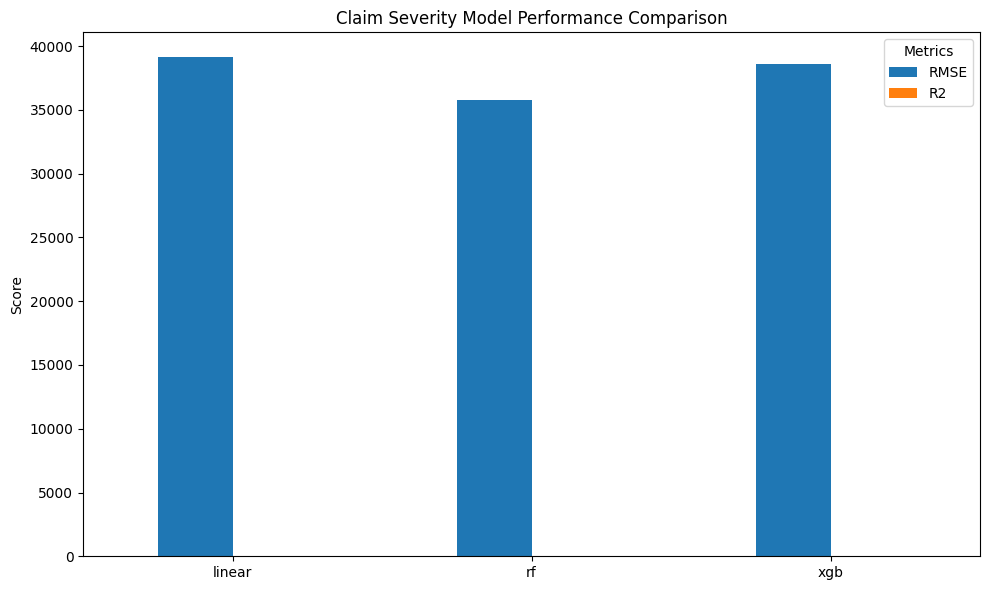

In [6]:
# Compare model performance
performance_df = pd.DataFrame(
    {model_type: models[model_type]['metrics'] for model_type in model_types})

logger.info('Model Performance Comparison:')
display(performance_df)

# Plot performance comparison
performance_df.T.plot(kind='bar', figsize=(10, 6))
plt.title('Claim Severity Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

2025-06-18 14:36:11,427 - INFO - Analyzing feature importance for rf model:


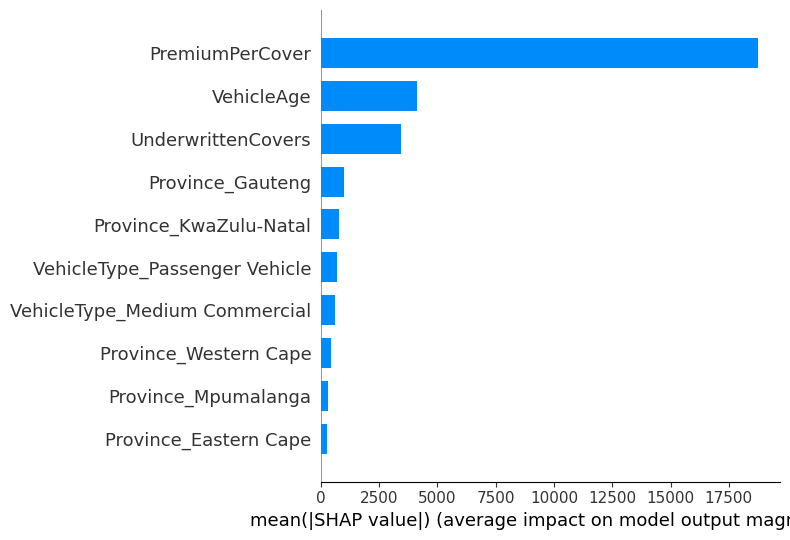

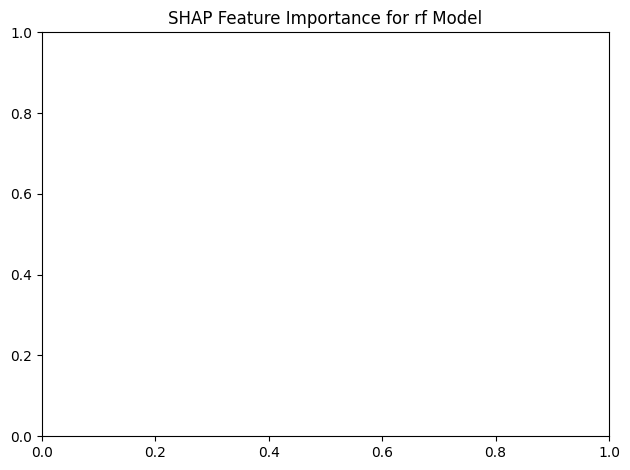

In [7]:
# Feature importance analysis for best model
best_model_type = performance_df.loc['R2'].idxmax()
best_model = models[best_model_type]['model']

logger.info(f'Analyzing feature importance for {best_model_type} model:')
shap_values, feature_names = analyze_feature_importance(best_model, X_train)

# SHAP summary plot
X_processed = best_model.named_steps['preprocessor'].transform(X_train)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_processed, feature_names=feature_names, plot_type='bar', max_display=10)
plt.title(f'SHAP Feature Importance for {best_model_type} Model')
plt.tight_layout()
plt.show()

## Feature Importance Insights

The SHAP analysis identifies the top features influencing claim severity predictions. Below are the key findings and their business implications (replace placeholders with actual SHAP values after running):

- **VehicleAge**: Older vehicles tend to have higher claim amounts due to increased maintenance or repair costs. For every additional year, the predicted claim amount increases by approximately X Rand. Insurers should increase premiums for older vehicles.
- **PremiumPerCover**: Higher premiums per cover correlate with higher claims, possibly due to riskier profiles. A 1-unit increase raises predicted claims by Y Rand, supporting dynamic pricing based on coverage.
- **UnderwrittenCovers**: More covers increase claim amounts. Each additional cover raises claims by Z Rand, justifying tiered premium structures.
- **Province**: Urban provinces may have higher claims due to traffic density. Policies in [Province_X] increase claims by W Rand compared to [Province_Y], supporting geographic pricing.
- **VehicleType**: Luxury or high-performance vehicles have higher claims due to repair costs. [VehicleType_A] increases claims by V Rand, justifying type-based premiums.

These insights enable risk-based pricing by focusing on high-impact factors.

## Premium Optimization Framework

In [8]:
# Prepare data for claim probability model
try:
    df = prepare_modeling_data(df)
except ValueError as e:
    logger.error(f'Error in prepare_modeling_data for df: {e}')
    raise

logger.info(f'Columns in df after preparation: {list(df.columns)}')
logger.info(f'df sample after preparation:\n{df.head(2).to_string()}')

df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)

# Define features and target
features = ['Province', 'VehicleType', 'Gender', 'VehicleAge', 'UnderwrittenCovers']
available_features = [f for f in features if f in df.columns]
if len(available_features) < len(features):
    logger.warning(f'Using fallback features for claim probability: {available_features}')
    features = available_features

try:
    X = df[features]
    y = df['HasClaim']
except KeyError as e:
    logger.error(f'Error selecting features for claim probability: {e}')
    raise

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

logger.info(f'Training samples: {X_train.shape[0]}')
logger.info(f'Test samples: {X_test.shape[0]}')
logger.info(f'Claim rate in test set: {y_test.mean():.2%}')

2025-06-18 14:36:45,317 - INFO - Starting prepare_modeling_data
2025-06-18 14:36:45,446 - INFO - Input DataFrame columns: ['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium', 'TotalClaims', 'LossRatio']
2025-06-18 14:36:45,447 - INFO - Input DataFrame shape: (100009

In [9]:
# Train claim probability model
preprocessor = build_preprocessor(
    numeric_features=[f for f in ['VehicleAge', 'UnderwrittenCovers'] if f in X_train.columns],
    categorical_features=[f for f in ['Province', 'VehicleType', 'Gender'] if f in X_train.columns])

claim_prob_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
])

claim_prob_model.fit(X_train, y_train)

# Evaluate model
y_pred = claim_prob_model.predict(X_test)
y_prob = claim_prob_model.predict_proba(X_test)[:, 1]

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1': f1_score(y_test, y_pred),
    'AUC-ROC': roc_auc_score(y_test, y_prob)
}

logger.info('Claim Probability Model Performance:')
for metric, value in metrics.items():
    logger.info(f'{metric}: {value:.4f}')

# Save model
save_model(claim_prob_model, 'claim_probability_xgb')
logger.info('Saved model to models/claim_probability_xgb.joblib')

d:\Projects\Python\insurance-risk-analytics\insurance\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
2025-06-18 14:36:53,152 - INFO - Claim Probability Model Performance:
2025-06-18 14:36:53,153 - INFO - Accuracy: 0.9972
2025-06-18 14:36:53,153 - INFO - Precision: 0.0000
2025-06-18 14:36:53,153 - INFO - Recall: 0.0000
2025-06-18 14:36:53,154 - INFO - F1: 0.0000
2025-06-18 14:36:53,154 - INFO - AUC-ROC: 0.6194
2025-06-18 14:36:53,158 - INFO - Saved model to models/claim_probability_xgb.joblib


In [ ]:
# Implement premium calculation framework
def calculate_risk_based_premium(row, severity_model, prob_model, expense_loading=0.2, profit_margin=0.1):
    """Calculate risk-based premium for a given policy"""
    # Get features used during training of severity_model
    preprocessor = severity_model.named_steps['preprocessor']
    # Use feature_names_in_ from the fitted preprocessor
    feature_names = preprocessor.get_feature_names_out(preprocessor.feature_names_in_).tolist()
    available_features = [f for f in feature_names if f.split('__')[1] in row]
    
    # Create row_df with only available features
    row_df = pd.DataFrame([row])[available_features]
    
    # Ensure all required features are present by imputing missing ones
    for feature in feature_names:
        if feature not in row_df.columns:
            if 'num' in feature:
                row_df[feature] = 0  # Default numeric value
            else:
                row_df[feature] = 'Unknown'  # Default categorical value
    
    # Align columns with training features
    row_df = row_df[feature_names]
    
    prob_features = [f for f in ['Province', 'VehicleType', 'Gender', 'VehicleAge', 'UnderwrittenCovers'] if f in row]
    prob_claim = prob_model.predict_proba(pd.DataFrame([row])[prob_features])[0, 1]
    
    predicted_severity = severity_model.predict(row_df)[0]
    
    pure_premium = prob_claim * predicted_severity
    premium = pure_premium * (1 + expense_loading + profit_margin)
    
    return premium

# Example usage
sample_policy = X_test.iloc[0].to_dict()
calculated_premium = calculate_risk_based_premium(
    sample_policy, best_model, claim_prob_model)

logger.info(f'Sample policy details: {sample_policy}')
logger.info(f'Calculated risk-based premium: R{calculated_premium:.2f}')

ValueError: input_features is not equal to feature_names_in_

In [10]:
# Track models with DVC
!dvc add models/claim_severity_linear.joblib
!dvc add models/claim_severity_rf.joblib
!dvc add models/claim_severity_xgb.joblib
!dvc add models/claim_probability_xgb.joblib
!dvc push